In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs 

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


## Specify dataset

In [2]:
num_steps = 2000 #5000
num_states = 10*10 #10*10
# input = inputs.Sim2DLevyFlight(
#     num_steps=num_steps,
#     walls=9,
#     alpha=2,
#     beta=1
#     )

input = inputs.Sim2DWalk(
    num_steps=num_steps,
    num_states=num_states
    )

# input = inputs.Sim1DWalk(
#     num_steps=num_steps,
#     num_states=num_states
#     )


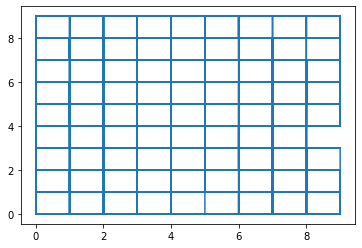

In [3]:
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

## Specify model you want to test

In [13]:
model_path = '../trained_models/0.4/'
model_file = model_path + 'model.pt'
configs_file = model_path + 'net_configs.p'

if os.path.isfile(configs_file):
    with open(configs_file, 'rb') as f:
        net_configs = pickle.load(f)
    net = STDP_SR(
        num_states=num_states, gamma=net_configs['gamma'],
        ca3_kwargs=net_configs['ca3_kwargs']
        )
else:
    print("Loading default")
    output_params = {
        'num_iterations':100, 'transform_input': False,
        'input_clamp': 100, 'nonlinearity': 'clamp'
        }
    gamma = 0.9
#     output_params = {
#         'num_iterations':np.inf, 'transform_input': False,
#         'input_clamp': 100, 'nonlinearity': 'clamp'
#         }
#     gamma = 0.4
    net = STDP_SR(
        num_states=num_states, gamma=gamma,
        ca3_kwargs={'output_params':output_params}
        )
    
net.load_state_dict(torch.load(model_file))
net.ca3.set_differentiability(False) 

In [14]:
dg_inputs = torch.from_numpy(input.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(input.dg_modes.T).float().to(device).unsqueeze(1)
with torch.no_grad():
    _, outputs = net(dg_inputs, dg_modes, reset=True)
    rnn_T = net.ca3.get_T().detach().numpy()
    est_T = net.ca3.get_ideal_T_estimate()
    error = np.mean(np.abs(est_T - rnn_T))
    print(f'Error at last timestep: {error}')
    mse = np.mean(np.square(est_T - rnn_T))
    print(mse)

Error at last timestep: 1.0118494773120864e-05
8.080721250646869e-08


# Plot T matrix

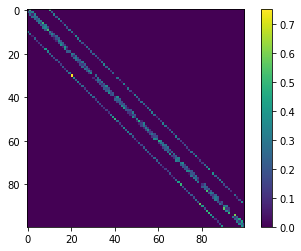

In [15]:
plt.figure()
plt.imshow(net.ca3.get_T())
plt.colorbar()
plt.show()

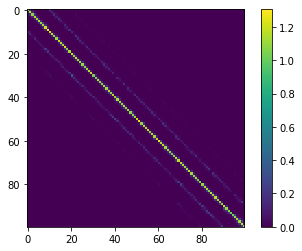

In [16]:
plt.figure()
plt.imshow(net.ca3.get_ideal_M())
plt.colorbar()
plt.show()

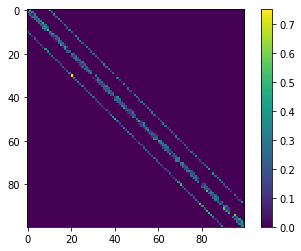

In [17]:
plt.figure()
plt.imshow(net.ca3.get_ideal_T_estimate())
plt.colorbar()
plt.show()

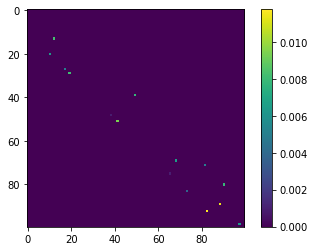

In [18]:
plt.figure()
plt.imshow(net.ca3.get_ideal_T_estimate()-net.ca3.get_T().detach().numpy())
plt.colorbar()
plt.show()

In [19]:
x = net.ca3.get_ideal_T_estimate()-net.ca3.get_T().detach().numpy()
np.mean(x)

9.850005547156436e-06

## Plot outputs

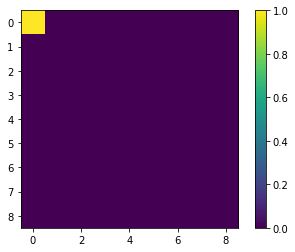

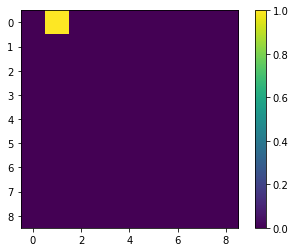

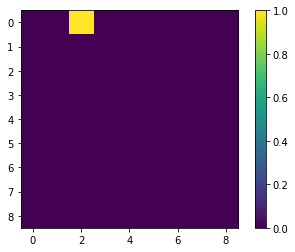

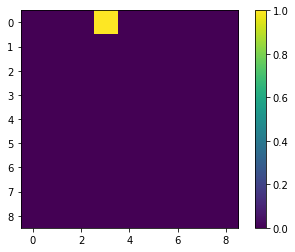

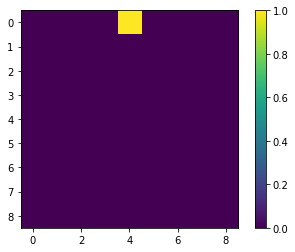

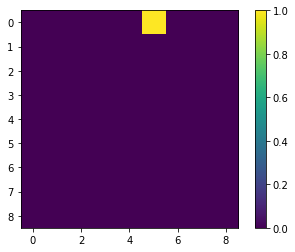

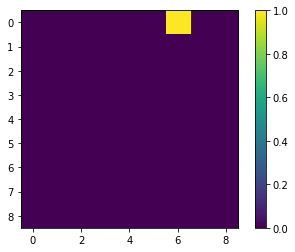

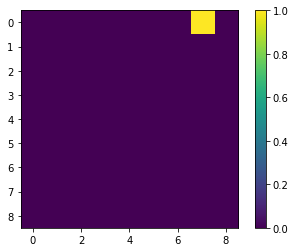

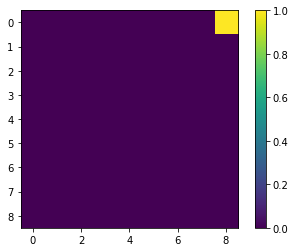

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


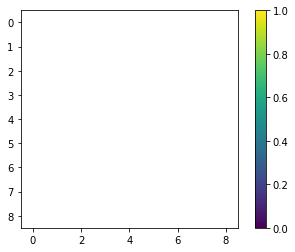

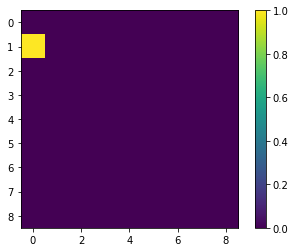

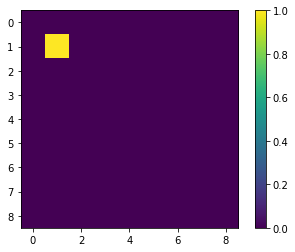

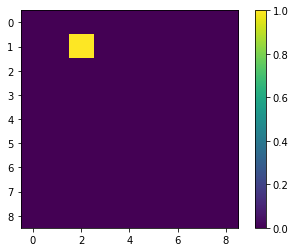

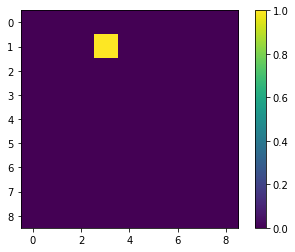

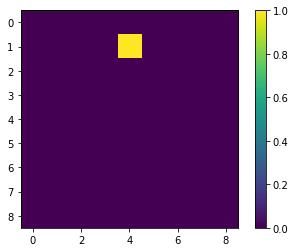

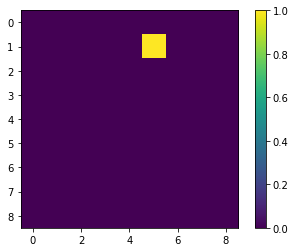

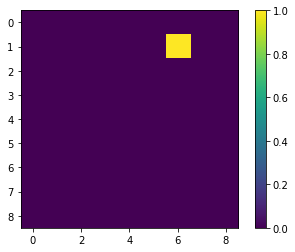

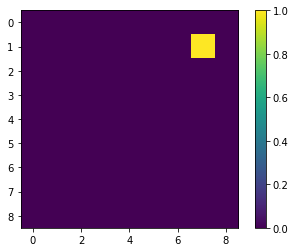

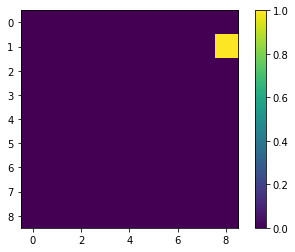

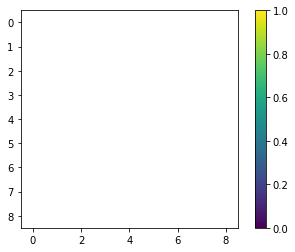

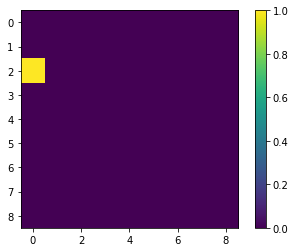

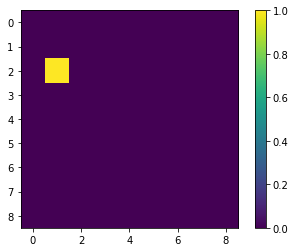

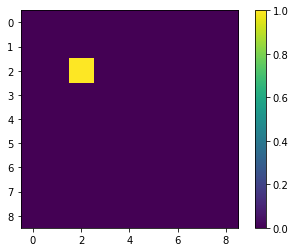

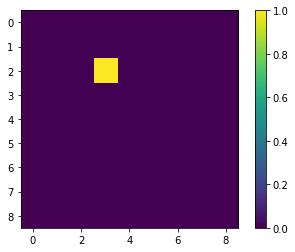

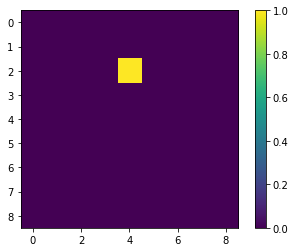

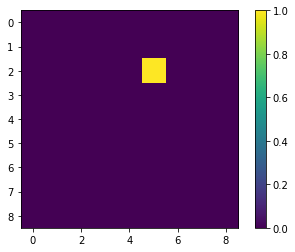

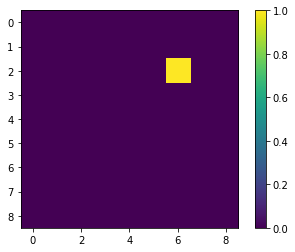

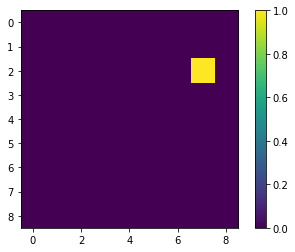

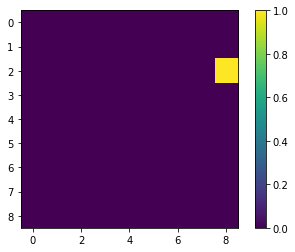

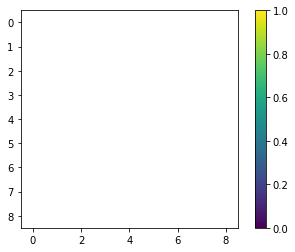

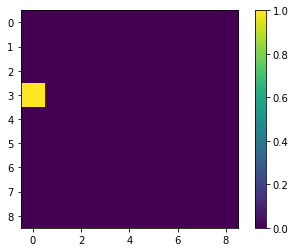

KeyboardInterrupt: 

In [20]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur].numpy())
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

## Plot columns of M

In [16]:
M = net.ca3.get_M_hat(0.9)

# M = np.eye(M.shape[0])
# T = net.ca3.get_T().detach().numpy()
# for _ in range(1,10):
#     M += (0.9**_ * np.linalg.matrix_power(T, _))

M = net.ca3.get_ideal_M(0.9)

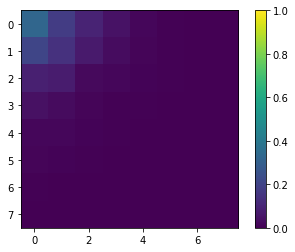

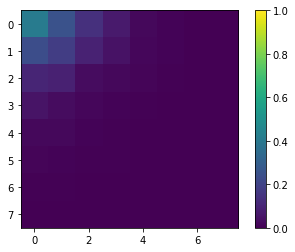

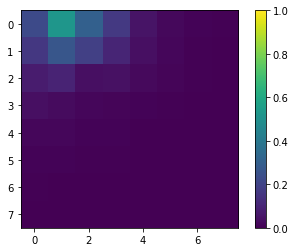

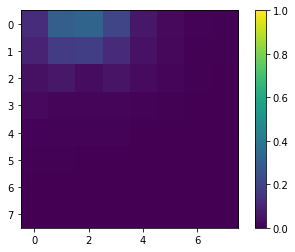

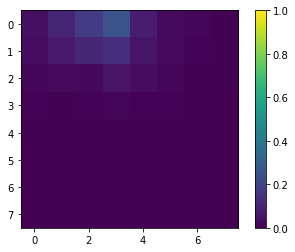

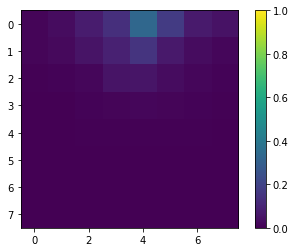

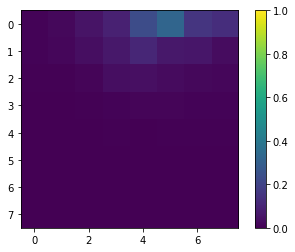

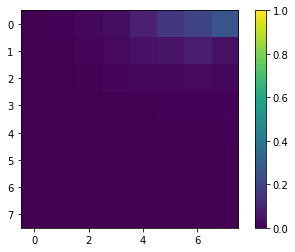

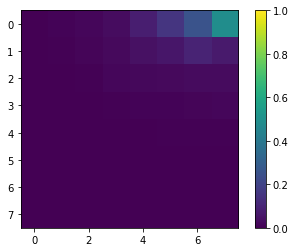

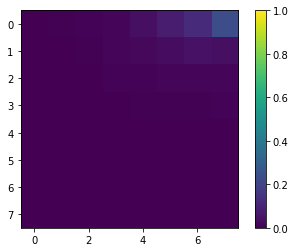

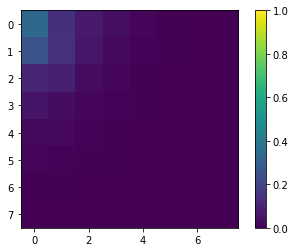

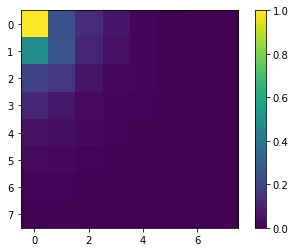

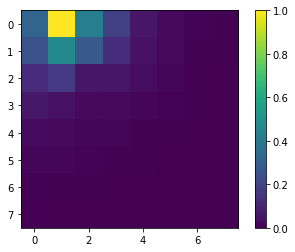

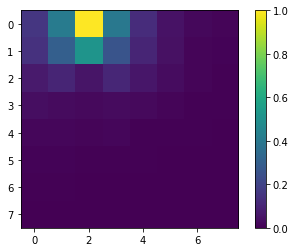

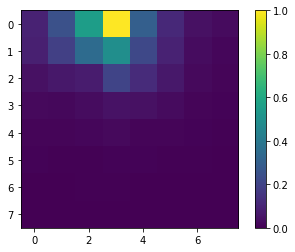

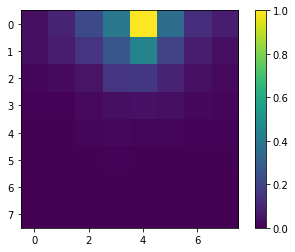

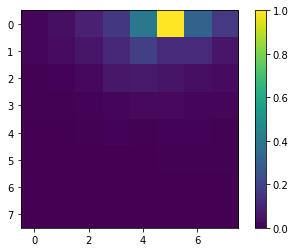

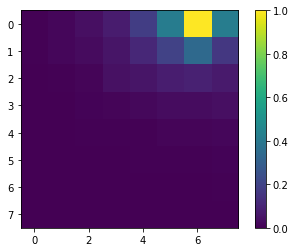

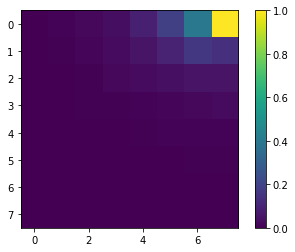

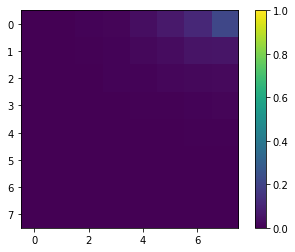

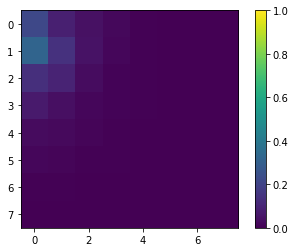

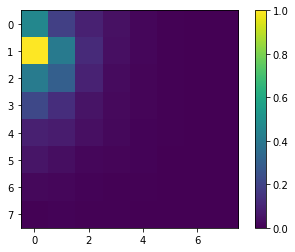

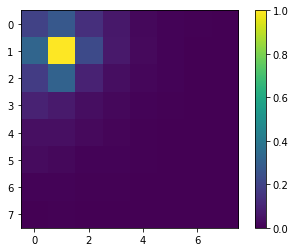

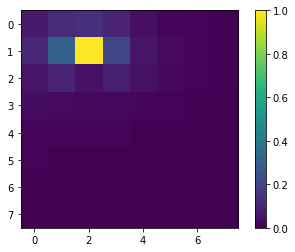

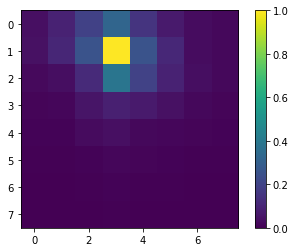

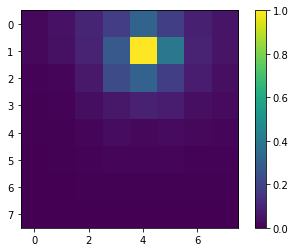

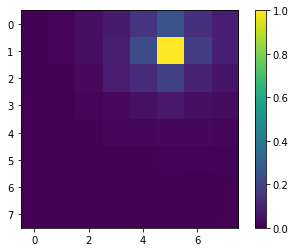

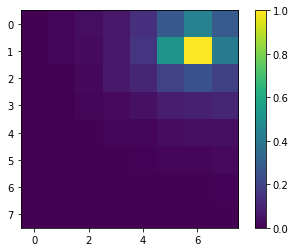

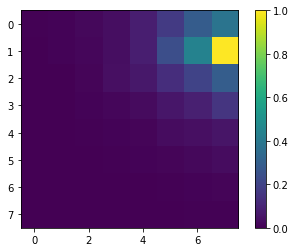

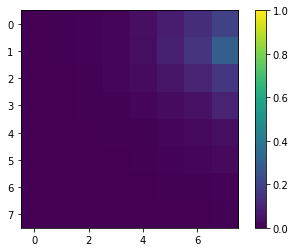

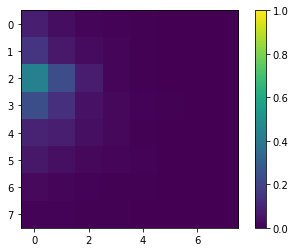

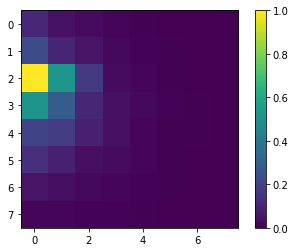

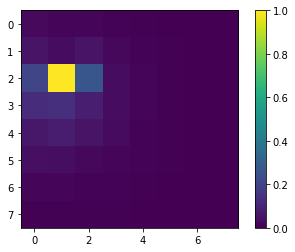

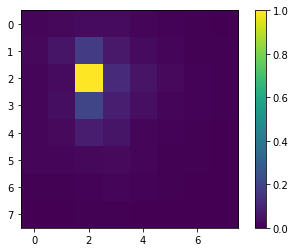

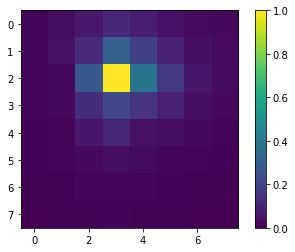

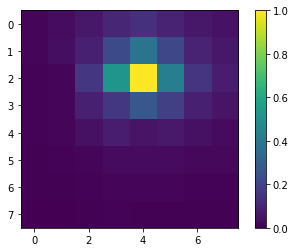

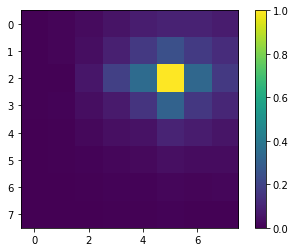

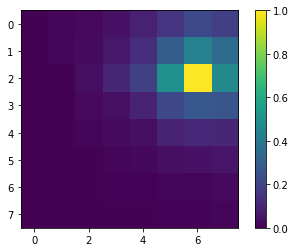

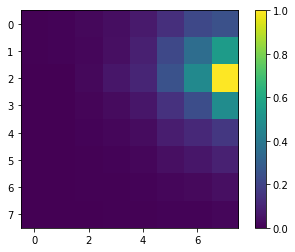

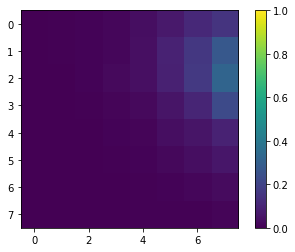

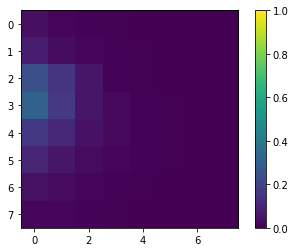

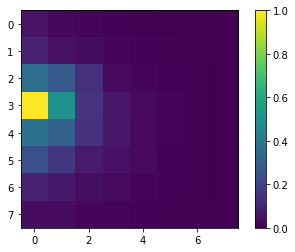

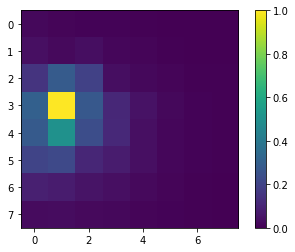

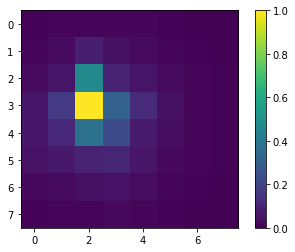

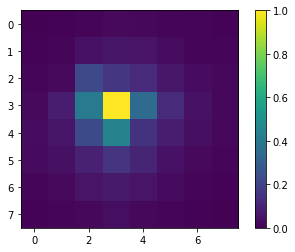

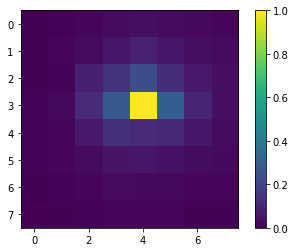

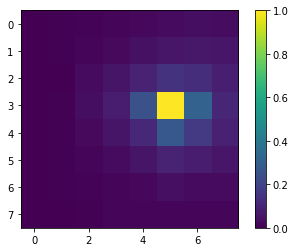

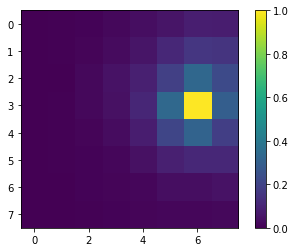

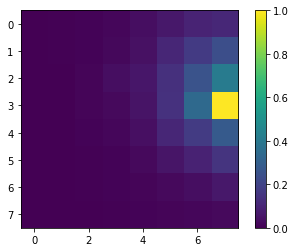

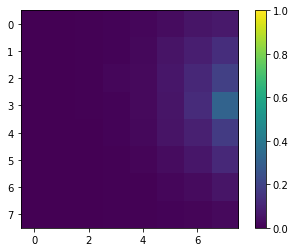

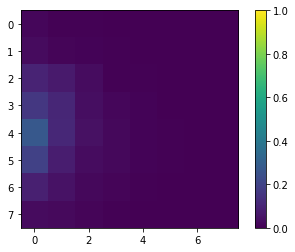

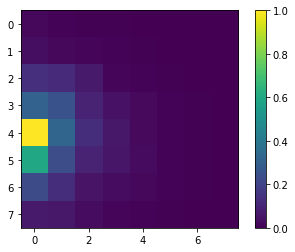

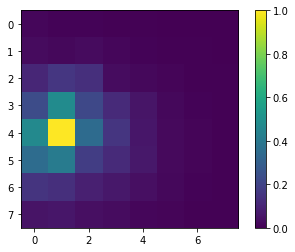

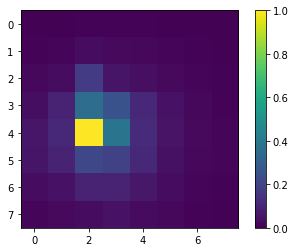

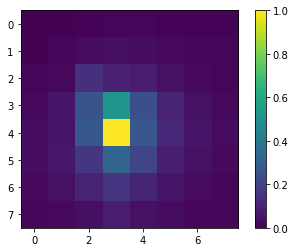

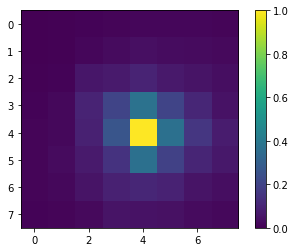

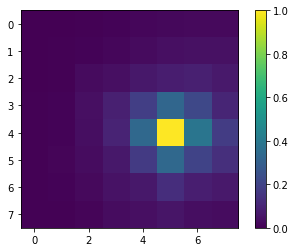

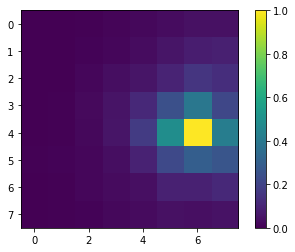

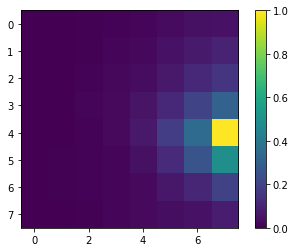

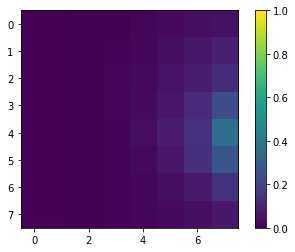

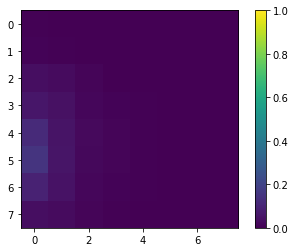

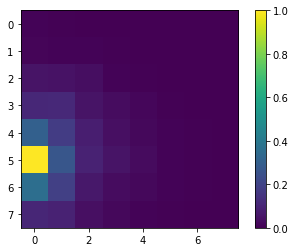

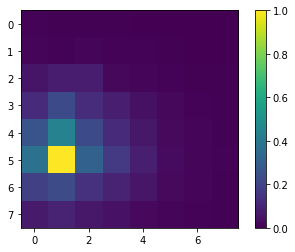

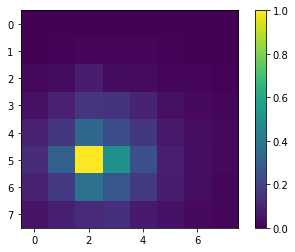

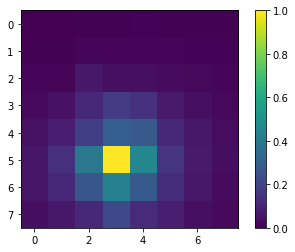

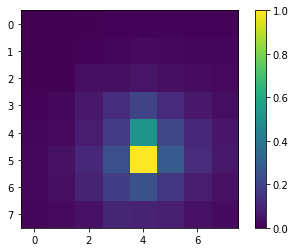

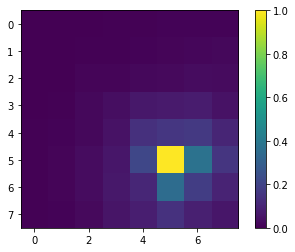

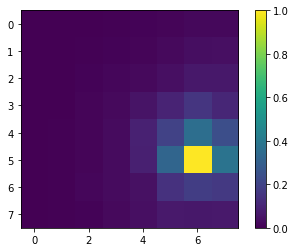

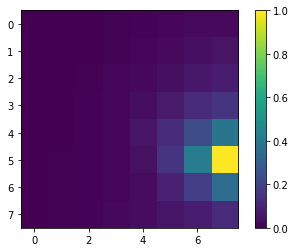

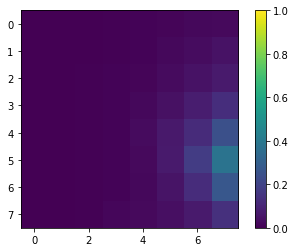

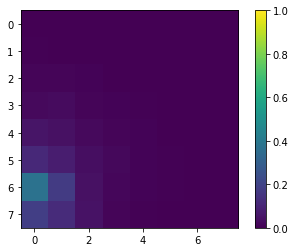

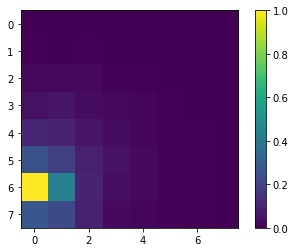

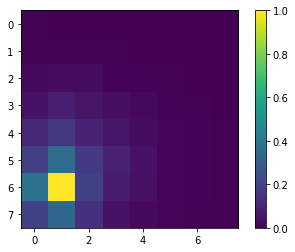

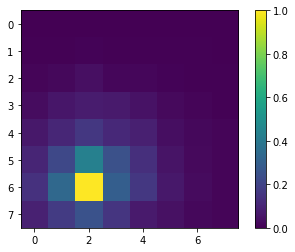

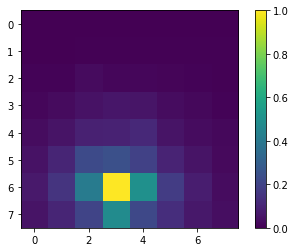

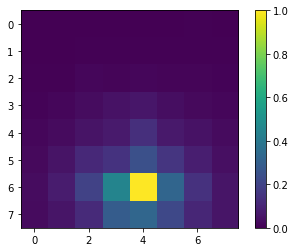

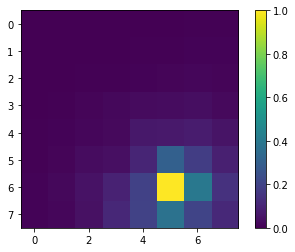

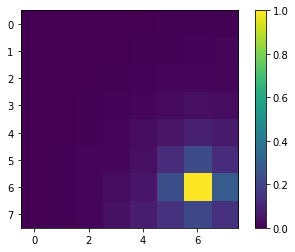

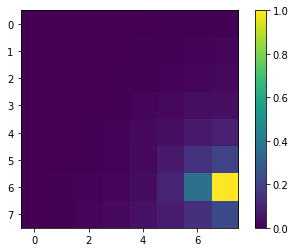

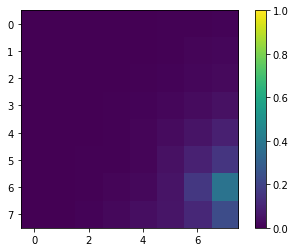

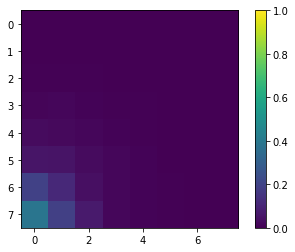

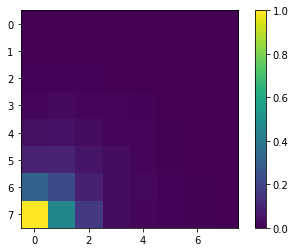

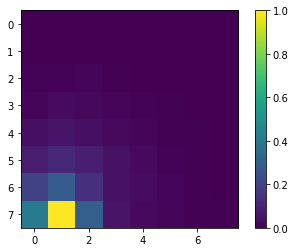

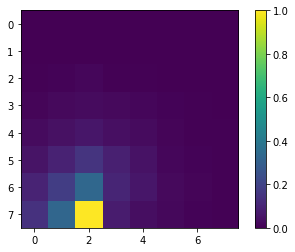

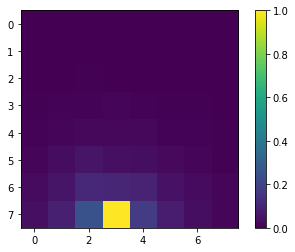

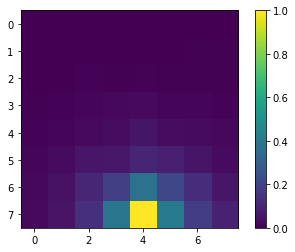

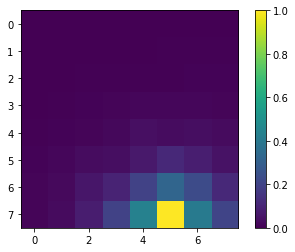

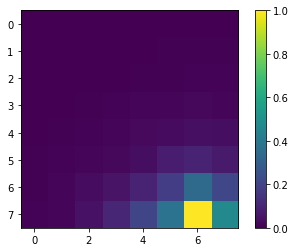

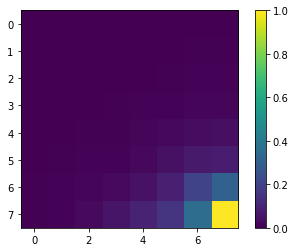

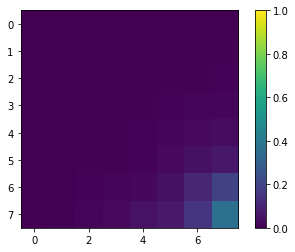

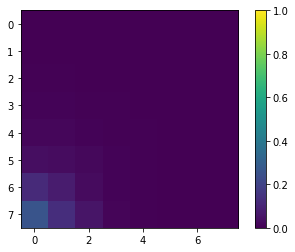

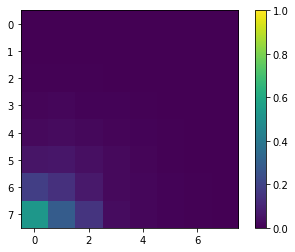

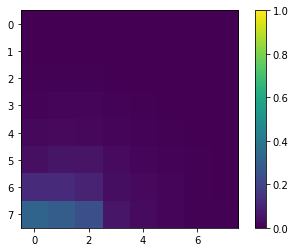

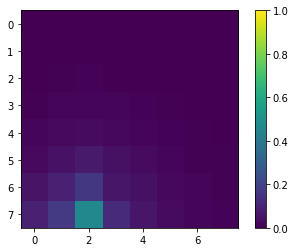

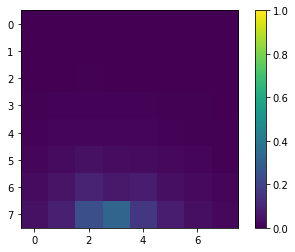

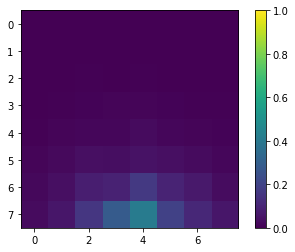

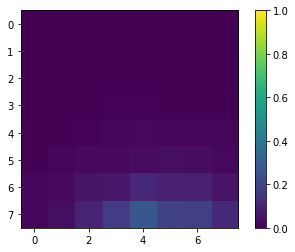

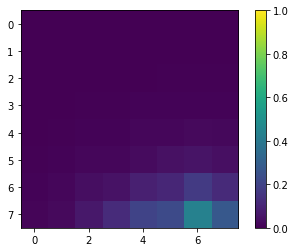

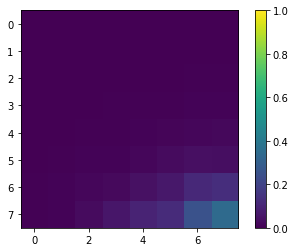

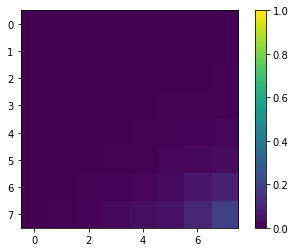

In [17]:
for col in range(M.shape[1]):
    firing_field = M[:,col].detach().numpy()
    num_walls = int(np.sqrt(firing_field.size))
    firing_field =firing_field.reshape((num_walls,num_walls))
    plt.figure()
    plt.imshow(firing_field[1:-1, 1:-1]/firing_field.max(), vmin=0, vmax=1)#[1:-1, 1:-1])
    plt.colorbar()
    plt.show()